# Born to slide: mobile origin licensing factors confer resistance to transcription conflicts

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ 1D
+ 1E
+ S1E
+ S1F
+ S1G
+ S1H

#### Archives:
+ Photobleaching_licensed-DNA_ATP.yama
+ Photobleaching_licensed-DNA_ATPgS.yama
+ Transcription_licensed-DNA_T7T_ATP.yama
+ Transcription_licensed-DNA_T7T_ATPgS.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from marspy.stats import bootstrap, calc_ci
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Photobleaching_licensed-DNA_ATP.yama',
                     'Photobleaching_licensed-DNA_ATPgS.yama',
                     'Transcription_licensed-DNA_T7T_ATP.yama',
                     'Transcription_licensed-DNA_T7T_ATPgS.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure1/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Photobleaching_licensed-DNA_ATP,1,221,SORT-LD555-ORC; ybbR-LD655-MCM,ATP,False,n/a,False,passed
Photobleaching_licensed-DNA_ATPgS,1,263,SORT-LD555-ORC; ybbR-LD655-MCM,ATPgS,False,n/a,False,passed
Transcription_licensed-DNA_T7T_ATP,2,653,SORT-LD555-ORC; ybbR-LD655-MCM,ATP,False,n/a,True,passed
Transcription_licensed-DNA_T7T_ATPgS,2,482,SORT-LD555-ORC; ybbR-LD655-MCM,ATPgS,False,n/a,True,passed


### Load segment tables, apply filter & calculate bleaching steps

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    for i in range(5):
        archive.filter_segments()
    try:
        archive.calc_bleaching_steps()
    except IndexError:
        # archives without bleaching data
        continue

### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''Sets up a 2-level df with all relevant information'''
    #indices will be UIDs
    #outside: set comprehension to cover all possible prefixes in all instances
    col_1 = sorted(list({prefix for prefix in archive.prefixes for archive in archive_instances}))
    #inside
    col_2 = 'position_on_dna bleaching_steps initial_intensity lifetime colocalization'.split()

    hier_index = pd.MultiIndex.from_product([col_1,col_2],names=['molecule','properties'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, bleaching_steps), (MCM_1_, colocalization), (MCM_1_, initial_intensity), (MCM_1_, lifetime), (MCM_1_, position_on_dna), (MCM_2_, bleaching_steps), (MCM_2_, colocalization), (MCM_2_, initial_intensity), (MCM_2_, lifetime), (MCM_2_, position_on_dna), (ORC_1_, bleaching_steps), (ORC_1_, colocalization), (ORC_1_, initial_intensity), (ORC_1_, lifetime), (ORC_1_, position_on_dna), (ORC_2_, bleaching_steps), (ORC_2_, colocalization), (ORC_2_, initial_intensity), (ORC_2_, lifetime), (ORC_2_, position_on_dna), (T7_1_, bleaching_steps), (T7_1_, colocalization), (T7_1_, initial_intensity), (T7_1_, lifetime), (T7_1_, position_on_dna)]
Index: []

[0 rows x 25 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #general columns first
        #this could be generalized with mol prefixes
        df.loc[molecule.uid,'number_orc'] = molecule.params['Number_ORC']
        df.loc[molecule.uid,'number_mcm'] = molecule.params['Number_MCM']
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()

        for prefix in molecule.prefixes:
            #mean position
            df.loc[molecule.uid,(prefix,'position_on_dna')] = molecule.df[prefix+'Position_on_DNA'].mean()

            #sometimes bleaching is rejected (reject_bleach_prefix)
            try:
                if not 'reject_bleach_'+prefix in molecule.tags:
                    #from attribute
                    df.loc[molecule.uid,(prefix,'bleaching_steps')] = molecule.bleaching_steps[prefix]

                #take intensity from corrected segment table (intensity in first segment)
                df.loc[molecule.uid,(prefix,'initial_intensity')] = \
                list(filter(lambda seg_df: seg_df.prefix == prefix, molecule.seg_dfs))[0].df.loc[0,'y1']
                
            except KeyError:
                # archives without bleaching data
                pass
            except AttributeError:
                # archives without bleaching data
                pass

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())

            #orc/mcm colocalization based on mean?
            #first set to False (default)
            df.loc[molecule.uid,(prefix,'colocalization')] = np.nan
            for other_prefix in molecule.prefixes:
                #only consider proteins different from current protein (prefix)
                if other_prefix.startswith(prefix.split('_')[0]):
                    #iterate to next prefix
                    continue

                #define colocalization if mean distance of both proteins is < 1000 bp
                elif abs(molecule.df[prefix+'Position_on_DNA'] - molecule.df[other_prefix+'Position_on_DNA']).mean() < 1000:
                    #set value to True and break out of loop
                    df.loc[molecule.uid,(prefix,'colocalization')] = other_prefix
                    break          
            
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


In [13]:
df.head()

molecule                        MCM_1_                                   \
properties             bleaching_steps colocalization initial_intensity   
3oMC7s51rZqNnNWPLohbmG             4.0            NaN      78463.289474   
653o2ZuSN8pMN1V7VqcpD              2.0         ORC_1_      42150.486842   
oE9icqkrb8fj68p6jYLqmR             3.0            NaN      49855.085366   
6DSzXgBzsUfnAmHAXp8dxQ             6.0            NaN     105181.025000   
k7EqL1pqSvrVSP7CxJGvH5             4.0         ORC_1_      67255.794872   

molecule                                                 MCM_2_  \
properties             lifetime position_on_dna bleaching_steps   
3oMC7s51rZqNnNWPLohbmG    536.0     3668.553790             1.0   
653o2ZuSN8pMN1V7VqcpD     333.0    15381.085561             NaN   
oE9icqkrb8fj68p6jYLqmR     59.0     3874.240401             NaN   
6DSzXgBzsUfnAmHAXp8dxQ    726.0     3838.545438             NaN   
k7EqL1pqSvrVSP7CxJGvH5    359.0     3820.842986             NaN   

molecule                                                          \
properties             colocalization initial_intensity lifetime   
3oMC7s51rZqNnNWPLohbmG            NaN          13857.25     22.0   
653o2ZuSN8pMN1V7VqcpD             NaN               NaN      NaN   
oE9icqkrb8fj68p6jYLqmR            NaN               NaN      NaN   
6DSzXgBzsUfnAmHAXp8dxQ            NaN               NaN      NaN   
k7EqL1pqSvrVSP7CxJGvH5            NaN               NaN      NaN   

molecule                                ...           T7_1_                 \
properties             position_on_dna  ... bleaching_steps colocalization   
3oMC7s51rZqNnNWPLohbmG    18872.273359  ...             NaN            NaN   
653o2ZuSN8pMN1V7VqcpD              NaN  ...             NaN            NaN   
oE9icqkrb8fj68p6jYLqmR             NaN  ...             NaN            NaN   
6DSzXgBzsUfnAmHAXp8dxQ             NaN  ...             NaN            NaN   
k7EqL1pqSvrVSP7CxJGvH5             NaN  ...             NaN            NaN   

molecule                                                          dna_length  \
properties             initial_intensity lifetime position_on_dna              
3oMC7s51rZqNnNWPLohbmG               NaN      NaN             NaN  31.339641   
653o2ZuSN8pMN1V7VqcpD                NaN      NaN             NaN  31.876794   
oE9icqkrb8fj68p6jYLqmR               NaN      NaN             NaN  36.426714   
6DSzXgBzsUfnAmHAXp8dxQ               NaN      NaN             NaN  33.557819   
k7EqL1pqSvrVSP7CxJGvH5               NaN      NaN             NaN  34.114366   

molecule               nucleotide number_mcm number_orc  \
properties                                                
3oMC7s51rZqNnNWPLohbmG        ATP        2.0        0.0   
653o2ZuSN8pMN1V7VqcpD         ATP        1.0        1.0   
oE9icqkrb8fj68p6jYLqmR        ATP        1.0        1.0   
6DSzXgBzsUfnAmHAXp8dxQ        ATP        1.0        0.0   
k7EqL1pqSvrVSP7CxJGvH5        ATP        1.0        1.0   

molecule                                    tags  
properties                                        
3oMC7s51rZqNnNWPLohbmG                  [accept]  
653o2ZuSN8pMN1V7VqcpD                   [accept]  
oE9icqkrb8fj68p6jYLqmR                  [accept]  
6DSzXgBzsUfnAmHAXp8dxQ  [accept, representative]  
k7EqL1pqSvrVSP7CxJGvH5                  [accept]  

[5 rows x 30 columns]

## Figures

### Figure 1D: MCM bleaching steps

In [14]:
# estimate standard error by bootstrapping

In [15]:
_plot_df = pd.DataFrame(columns=['bleaching_steps','nucleotide'])
protein = 'MCM'

for nuc in df['nucleotide'].unique():
    _temp_df = pd.DataFrame(data=(pd.melt(df[df['nucleotide']==nuc].filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))
                                  ['value'].dropna().value_counts(normalize=True).rename('probability').
                                  reset_index().sort_values('index')))
    _temp_df.columns = ['bleaching_steps','probability']
    _temp_df['nucleotide'] = nuc
    _plot_df = pd.concat([_plot_df,_temp_df])
    _plot_df = _plot_df.convert_dtypes()
    _plot_df.reset_index(drop=True,inplace=True)
_plot_df

,bleaching_steps,nucleotide,probability
0,1,ATP,0.059091
1,2,ATP,0.345455
2,3,ATP,0.095455
3,4,ATP,0.359091
4,5,ATP,0.059091
5,6,ATP,0.059091
6,7,ATP,0.018182
7,8,ATP,0.004545
8,1,ATPgS,0.948936
9,2,ATPgS,0.046809


In [16]:
for row in _plot_df.index:
    bootstrap_data = pd.DataFrame(data=(pd.melt(df[df['nucleotide']==_plot_df.loc[row,'nucleotide']].filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))['value'].dropna()))
    bootstrap_data['value'] = bootstrap_data['value'].apply(lambda value: 1 if value == _plot_df.loc[row,'bleaching_steps'] else 0)
    bootstrap_means = bootstrap(bootstrap_data['value'],n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
_plot_df

,bleaching_steps,nucleotide,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,1,ATP,0.059091,0.058976,0.015799,0.045455,0.072727,0.031818,0.090909
1,2,ATP,0.345455,0.345071,0.032311,0.313636,0.377273,0.281818,0.409091
2,3,ATP,0.095455,0.095632,0.019692,0.077273,0.113636,0.059091,0.136364
3,4,ATP,0.359091,0.359095,0.032262,0.327273,0.390909,0.295455,0.422727
4,5,ATP,0.059091,0.058906,0.015983,0.040909,0.072727,0.031818,0.090909
5,6,ATP,0.059091,0.059226,0.015802,0.045455,0.072727,0.031818,0.090909
6,7,ATP,0.018182,0.018204,0.009089,0.009091,0.027273,0.004545,0.036364
7,8,ATP,0.004545,0.004586,0.004565,0.000000,0.009091,0.000000,0.013636
8,1,ATPgS,0.948936,0.949006,0.014319,0.936170,0.961702,0.919149,0.974468
9,2,ATPgS,0.046809,0.046681,0.013731,0.034043,0.059574,0.021277,0.076596


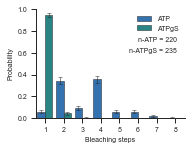

In [17]:
fig,axes = plt.subplots()
protein = 'MCM'
_plot_df.groupby(['bleaching_steps','nucleotide'])['probability'].sum().unstack().plot(kind='bar', width=0.8, ax=axes,lw=0.5, edgecolor='.15',
                                                                                       color=[sns.desaturate(palettes['MCM'][1],0.75),sns.desaturate(palettes['OCCM'][1],0.75)],
                                                                                       error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                                                                                       yerr=_plot_df.groupby(['bleaching_steps','nucleotide'])['standard_error'].sum().unstack())
axes.set_xlim(-0.5,7.5)
axes.set_ylim(0,1)
axes.set_xlabel('Bleaching steps')
axes.set_ylabel('Probability')

axes.text(0.95, 0.75, f"n-ATP = {len(pd.melt(df[df['nucleotide']=='ATP'].filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='.15')
axes.text(0.95, 0.65, f"n-ATPgS = {len(pd.melt(df[df['nucleotide']=='ATPgS'].filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes,
        color='.15')

plt.xticks(rotation=0)
plt.legend(frameon=False,loc=1)
sns.despine()
plt.savefig(dir_out+'1D_MCM_bleaching_hueNuc.svg',transparent=True)


### Figure 1E: ORC bleaching steps

In [18]:
# estimate standard error by bootstrapping

In [19]:
_plot_df = pd.DataFrame(columns=['bleaching_steps','nucleotide'])
protein = 'ORC'

for nuc in df['nucleotide'].unique():
    _temp_df = pd.DataFrame(data=(pd.melt(df[df['nucleotide']==nuc].filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))
                                  ['value'].dropna().value_counts(normalize=True).rename('probability').
                                  reset_index().sort_values('index')))
    _temp_df.columns = ['bleaching_steps','probability']
    _temp_df['nucleotide'] = nuc
    _plot_df = pd.concat([_plot_df,_temp_df])
    _plot_df = _plot_df.convert_dtypes()
    _plot_df.reset_index(drop=True,inplace=True)
_plot_df

,bleaching_steps,nucleotide,probability
0,1,ATP,0.861702
1,2,ATP,0.106383
2,3,ATP,0.031915
3,1,ATPgS,0.903061
4,2,ATPgS,0.096939


In [20]:
for row in _plot_df.index:
    bootstrap_data = pd.DataFrame(data=(pd.melt(df[df['nucleotide']==_plot_df.loc[row,'nucleotide']].filter(regex=(protein+"_"),axis=1)
                                          .xs('bleaching_steps',level='properties',axis=1))['value'].dropna()))
    bootstrap_data['value'] = bootstrap_data['value'].apply(lambda value: 1 if value == _plot_df.loc[row,'bleaching_steps'] else 0)
    bootstrap_means = bootstrap(bootstrap_data['value'],n_boot=10000)
    _plot_df.loc[row,'bs_mean'] = np.mean(bootstrap_means)
    _plot_df.loc[row,'standard_error'] = np.std(bootstrap_means)
    _plot_df.loc[row,'68_ci_lower'], _plot_df.loc[row,'68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
    _plot_df.loc[row,'95_ci_lower'], _plot_df.loc[row,'95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
_plot_df

,bleaching_steps,nucleotide,probability,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper
0,1,ATP,0.861702,0.861878,0.035296,0.829787,0.893617,0.787234,0.925532
1,2,ATP,0.106383,0.105894,0.031261,0.074468,0.138298,0.053191,0.170213
2,3,ATP,0.031915,0.031730,0.017964,0.010638,0.053191,0.000000,0.074468
3,1,ATPgS,0.903061,0.903106,0.021279,0.882653,0.923469,0.857143,0.943878
4,2,ATPgS,0.096939,0.097278,0.021081,0.076531,0.117347,0.056122,0.137755


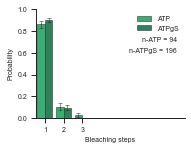

In [21]:
fig,axes = plt.subplots()
protein = 'ORC'
_plot_df.groupby(['bleaching_steps','nucleotide'])['probability'].sum().unstack().plot(kind='bar', width=0.8, ax=axes,lw=0.5, edgecolor='.15',
                                                                                       color=[sns.desaturate(palettes[protein][1],0.75),sns.desaturate(palettes[protein][3],0.75)],
                                                                                       error_kw=dict(ecolor='.15', lw=0.5, capsize=2, capthick=0.5),
                                                                                       yerr=_plot_df.groupby(['bleaching_steps','nucleotide'])['standard_error'].sum().unstack())
axes.set_xlim(-0.5,7.5)
axes.set_ylim(0,1)
axes.set_xlabel('Bleaching steps')
axes.set_ylabel('Probability')

axes.text(0.95, 0.75, f"n-ATP = {len(pd.melt(df[df['nucleotide']=='ATP'].filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)
axes.text(0.95, 0.65, f"n-ATPgS = {len(pd.melt(df[df['nucleotide']=='ATPgS'].filter(regex=(protein+'_'),axis=1).xs('bleaching_steps',level='properties',axis=1))['value'].dropna())}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

plt.xticks(rotation=0)
plt.legend(frameon=False,loc=1)
sns.despine()
plt.savefig(dir_out+'1E_ORC_bleaching_hueNuc.svg',transparent=True)


### Figure S1E: MCM bleaching trajectories

In [22]:
example_molecules_atp_uid = ['sc7XcNAgUwYRSrNDLAZ8gU','2mc2iKhd2nps2mNmEbY19V','7xFMFh6FAVBE6o43oRrHuj','twz6GxzAWHfFvMubfHXyVH']
example_molecules_atpgs_uid = ['dTWpa7iPTQ9zDqRtE3V2EJ','9CtFLGKSFNwq3VNNH6S7W8','cwr8DRcz5zKg1EaDVzrN9m','jzSPiaQJiLWW53AXpb9anw']

In [23]:
example_molecules_atp = []
example_molecules_atpgs = []
# grab molecule objects
for uid in example_molecules_atp_uid:
    for archive in DnaMoleculeArchive.instances:
        try:
            example_molecules_atp.append(archive.get_molecule_by_uid(uid))
            break
        except IndexError:
            continue
            
for uid in example_molecules_atpgs_uid:
    for archive in DnaMoleculeArchive.instances:
        try:
            example_molecules_atpgs.append(archive.get_molecule_by_uid(uid))
            break
        except IndexError:
            continue

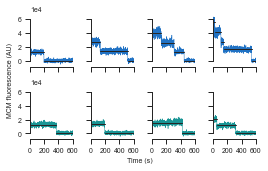

In [24]:
protein = 'MCM'
fig,axes=plt.subplots(2,4,figsize=(4,2.5),sharex=True, sharey=True)

# ATP
col_counter = 0

for molecule in example_molecules_atp:
    
    sns.lineplot(x='MCM_1_Time (s)', y='MCM_1_Intensity',data=molecule.df,
                 ax=axes[0,col_counter],color=palettes['MCM'][1],lw=0.5)
    
    for seg_df in molecule.seg_dfs:
        if seg_df.prefix == 'MCM_1_':
            for row in seg_df.df.index:
                temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['x1','y1']].values, seg_df.df.loc[row,['x2','y2']].values],columns=['x','y'])
                sns.lineplot(x='x', y='y',data=temp_df,ax=axes[0,col_counter],color='0.15',lw=1)
            break
    
    col_counter+=1


# ATPgS
col_counter = 0

for molecule in example_molecules_atpgs:
    
    sns.lineplot(x='MCM_1_Time (s)', y='MCM_1_Intensity',data=molecule.df,
                 ax=axes[1,col_counter],color=palettes['OCCM'][1],lw=0.5)
    
    for seg_df in molecule.seg_dfs:
        if seg_df.prefix == 'MCM_1_':
            for row in seg_df.df.index:
                temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['x1','y1']].values, seg_df.df.loc[row,['x2','y2']].values],columns=['x','y'])
                sns.lineplot(x='x', y='y',data=temp_df,ax=axes[1,col_counter],color='.15',lw=1)
            break
    
    col_counter+=1
        
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'MCM fluorescence (AU)', va='center', rotation='vertical')
        
for ax_array in axes:
    for ax in ax_array:
        ax.set_xlabel(None)
        ax.set_ylabel(None)


plt.xticks([0,200,400,600])
plt.yticks([0,20000,40000,60000])
plt.xlim(0,600)
#plt.ylim([-3000,60000])
plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
#fig.suptitle('Photobleaching confirms MCM DH formation')

sns.despine(trim=True)

fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.savefig(dir_out+"S1E_MCM_bleaching_trajectories_hueNuc.svg",transparent=True)

### Figure S1F: ORC-MCM colocalization

In [25]:
# estimate standard error by bootstrapping

In [26]:
_plot_df = pd.DataFrame(columns=['protein','nucleotide'])
proteins = ['MCM','','ORC']
for protein in proteins:
    if protein == '':
        _temp_df = pd.DataFrame(data=[0])
        _temp_df.columns = ['probability']
        _temp_df['protein'] = ''
        _temp_df['nucleotide'] = ''
        _temp_df['nobs'] = 0
        _temp_df['bs_mean'] = 0
        _temp_df['standard_error'] = 0
        _temp_df['68_ci_lower'], _temp_df['68_ci_upper'] = (0,0)
        _temp_df['95_ci_lower'], _temp_df['95_ci_upper'] = (0,0)
        
        _plot_df = pd.concat([_plot_df,_temp_df])
        _plot_df = _plot_df.convert_dtypes()
        _plot_df.reset_index(drop=True,inplace=True)
        continue
        
    for nuc in df['nucleotide'].unique():
        _temp_df = pd.DataFrame(data=[df[df['nucleotide']==nuc].filter(regex=(protein+'_'),axis=1).xs('colocalization',level='properties',axis=1).notnull().sum().sum()
                    /df[df['nucleotide']==nuc]['number_'+protein.lower()].sum()])
        _temp_df.columns = ['probability']
        _temp_df['protein'] = protein
        _temp_df['nucleotide'] = nuc
        
        # bootstrapping
        not_null_count = int(df[df['nucleotide']==nuc].filter(regex=(protein+'_'),axis=1).xs('colocalization',level='properties',axis=1).notnull().sum().sum())
        total_count = int(df[df['nucleotide']==nuc]['number_'+protein.lower()].sum())
        
        _temp_df['nobs'] = total_count
        # generate list with 1 for colocalization and 0 for no colocalization
        bootstrap_data = ([0 for _ in range(total_count - not_null_count)] +
                          [1 for _ in range(not_null_count)])
        
        bootstrap_means = bootstrap(bootstrap_data,n_boot=10000)
        _temp_df['bs_mean'] = np.mean(bootstrap_means)
        _temp_df['standard_error'] = np.std(bootstrap_means)
        _temp_df['68_ci_lower'], _temp_df['68_ci_upper'] = calc_ci(bootstrap_means,ci=68)
        _temp_df['95_ci_lower'], _temp_df['95_ci_upper'] = calc_ci(bootstrap_means,ci=95)
        
        _plot_df = pd.concat([_plot_df,_temp_df])
        _plot_df = _plot_df.convert_dtypes()
        _plot_df.reset_index(drop=True,inplace=True)
_plot_df['condition'] = _plot_df['protein'] +'-'+ _plot_df['nucleotide']
_plot_df

,protein,nucleotide,probability,nobs,bs_mean,standard_error,68_ci_lower,68_ci_upper,95_ci_lower,95_ci_upper,condition
0,MCM,ATP,0.415138,872,0.414970,0.016808,0.397936,0.431193,0.383028,0.448394,MCM-ATP
1,MCM,ATPgS,0.712050,639,0.712257,0.017792,0.694836,0.729264,0.677621,0.746479,MCM-ATPgS
2,,,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-
3,ORC,ATP,0.801802,333,0.801477,0.021878,0.780781,0.822823,0.756757,0.843844,ORC-ATP
4,ORC,ATPgS,0.785714,574,0.785734,0.017145,0.768293,0.803136,0.750871,0.818815,ORC-ATPgS


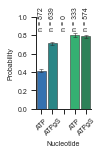

In [27]:
fig,axes = plt.subplots(figsize=(1,1.7))

sns.barplot(x='condition',y='probability',data=_plot_df, lw=0.5, edgecolor='.15', 
            palette=[palettes['MCM'][1],palettes['OCCM'][1],'k',palettes['ORC'][1],palettes['ORC'][3]],
            ax=axes)

plt.errorbar(x='condition',y='probability',data=_plot_df, yerr='standard_error',fmt='none',
             ecolor='.15', elinewidth=0.5, capsize=2, capthick=0.5, capstyle='round')

# number of observations
nobs = _plot_df['nobs']
nobs = [str(x) for x in nobs]
nobs = ["n = " + i for i in nobs]

#put nobs into plot
pos = range(len(nobs))
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 0.85, nobs[tick], rotation=90,
    horizontalalignment='center',verticalalignment='bottom')

axes.set_xlabel('Nucleotide')
axes.set_ylabel('Probability')
axes.set_xlim(-0.5,4.5)
axes.set_ylim(0,1)
axes.set_xticklabels(['ATP','ATPgS','','ATP','ATPgS'],rotation=45,)

sns.despine()

#fig.tight_layout()

plt.savefig(dir_out+"S1F_ORC_MCM_colocalization.svg",transparent=True)


### Figure S1G: 1ORC-6MCM bleaching trajectory

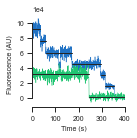

In [28]:
fig,axes=plt.subplots(figsize=(2,2))

# find molecule
for archive in DnaMoleculeArchive.instances:
        try:
            molecule = archive.get_molecule_by_uid('mJsocffox2tFJxP6NXcwF9')
            break
        except IndexError:
            continue

    
sns.lineplot(x='MCM_1_Time (s)', y='MCM_1_Intensity',data=molecule.df,
             ax=axes,color=palettes['MCM'][1],lw=0.5)
sns.lineplot(x='ORC_1_Time (s)', y='ORC_1_Intensity',data=molecule.df,
             ax=axes,color=palettes['ORC'][1],lw=0.5)

for seg_df in molecule.seg_dfs:
    if seg_df.prefix == 'MCM_1_':
        for row in seg_df.df.index:
            temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['x1','y1']].values, seg_df.df.loc[row,['x2','y2']].values],columns=['x','y'])
            sns.lineplot(x='x', y='y',data=temp_df,ax=axes,color='.15',lw=1)
        break

for seg_df in molecule.seg_dfs:
    if seg_df.prefix == 'ORC_1_':
        for row in seg_df.df.index:
            temp_df = pd.DataFrame(data=[seg_df.df.loc[row,['x1','y1']].values, seg_df.df.loc[row,['x2','y2']].values],columns=['x','y'])
            sns.lineplot(x='x', y='y',data=temp_df,ax=axes,color='.15',lw=1)
        break
    
       
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'Fluorescence (AU)', va='center', rotation='vertical')
        


axes.set_xlabel(None)
axes.set_ylabel(None)


#plt.xticks([0,200,400,600])
#plt.yticks([0,20000,40000,60000])
plt.xlim(0,400)
#plt.ylim([-3000,60000])
plt.ticklabel_format(axis="y", style="sci",scilimits=(4,4))
#fig.suptitle('Photobleaching confirms MCM DH formation')

sns.despine(trim=True)

fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.savefig(dir_out+"S1G_ORC_6MCM_bleaching_example.svg",transparent=True)

### Figure S1H: ORC-MCM bleaching correlation

In [29]:
#setup two dataframes for coloc bleaching analysis
df_coloc_mcm = pd.DataFrame(columns= ['MCM','ORC','nucleotide','uid'])
df_coloc_mcm

,MCM,ORC,nucleotide,uid


In [30]:
#this fills a dataframe containing all MCM bleaching steps and bleaching steps of colocalizing ORC if applicable

for prefix in {prefix for prefix in archive.prefixes for archive in DnaMoleculeArchive.instances}:
    #looping through all MCM
    if 'MCM' in prefix:
        #looping through all rows
        for row in df.index:
            #check if there is a valid MCM bleaching step
            if df.loc[row,prefix]['bleaching_steps'] > 0:
                try:
                    num_orc = df.loc[row,df.loc[row,prefix]['colocalization']]['bleaching_steps']
                except KeyError:
                    num_orc = 0
                    
                df_coloc_mcm = df_coloc_mcm.append({'MCM':df.loc[row,prefix]['bleaching_steps'],
                                            'ORC':num_orc,
                                            'nucleotide':df.loc[row,'nucleotide'][0],
                                            'uid':row},
                                           ignore_index=True)

df_coloc_mcm = df_coloc_mcm.infer_objects()
# remove events with 3 MCM bleaching in ATPgS condition (n number too low)
df_coloc_mcm = df_coloc_mcm[(df_coloc_mcm['MCM'] < 3) | (df_coloc_mcm['nucleotide'] == 'ATP')]

In [31]:
# correlation (pearson)
df_coloc_mcm[df_coloc_mcm['nucleotide']=='ATP'].corr()

,MCM,ORC
MCM,1.000000,0.011971
ORC,0.011971,1.000000


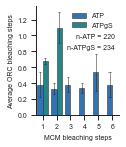

In [32]:
protein = 'MCM'
fig,axes=plt.subplots(figsize=(1.5,2))

sns.barplot(x=df_coloc_mcm['MCM'].apply(int),y='ORC',data=df_coloc_mcm,hue='nucleotide',palette=[palettes['MCM'][1],palettes['OCCM'][1]],
            n_boot=10000, seed=42, ci=68, lw=0.5, edgecolor='.15',
            ax=axes, errwidth=0.5,capsize=0.15,errcolor='.15')
axes.set_xlim(-0.5,5.5)
#axes.set_ylim(0,1.2)
axes.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
axes.set_xlabel('MCM bleaching steps')
axes.set_ylabel('Average ORC bleaching steps')
# axes.set_title('Avg ORC bleaching vs MCM bleaching')
plt.legend(frameon=False,loc=1)
sns.despine()

axes.text(0.95, 0.75, f"n-ATP = {df_coloc_mcm['nucleotide'].value_counts()['ATP']}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)
axes.text(0.95, 0.65, f"n-ATPgS = {df_coloc_mcm['nucleotide'].value_counts()['ATPgS']}",
        verticalalignment='top', horizontalalignment='right',
        transform=axes.transAxes)

plt.savefig(dir_out+"S1H_AvgORCbleach_vs_MCM_bleach.svg",transparent=True)